In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

## The model in theory

We are going to use 4 features: The **price** itself and three extra technical indicators.
- MACD (Trend)
- Stochastics (Momentum)
- Average True Range (Volume)

## Functions

**Exponential Moving Average:** Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. 
<img src="https://www.bionicturtle.com/images/uploads/WindowsLiveWriterGARCHapproachandExponentialsmoothingEWMA_863image_16.png">

**MACD:**  The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.
<img src="http://i68.tinypic.com/289ie1l.png">

**Stochastics oscillator:** The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

<img src="http://i66.tinypic.com/2vam3uo.png">

**Average True Range:** Is an indicator to measure the volalitility (NOT price direction). The largest of:
- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)

<img src="http://d.stockcharts.com/school/data/media/chart_school/technical_indicators_and_overlays/average_true_range_atr/atr-1-trexam.png" width="400px">

Calculation:
<img src="http://i68.tinypic.com/e0kggi.png">

In [2]:
def MACD(df,period1,period2,periodSignal):
    EMA1 = pd.DataFrame.ewm(df,span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df,span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    
    return Histogram

def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

## Read data

In [3]:
df = pd.read_csv('EURUSD.csv',usecols=[1,2,3,4])
df = df.iloc[::-1]
df["Close"] = (df["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Open"] = (df["Open"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["High"] = (df["High"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Low"] = (df["Low"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))


dfPrices = pd.read_csv('EURUSD.csv',usecols=[1])
dfPrices = dfPrices.iloc[::-1]
dfPrices["Close"] = (dfPrices["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))

In [4]:
dfPrices.head(2)

,Close
2629,1.3611
2628,1.3537


## Plot

In [5]:
price = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()

### Price

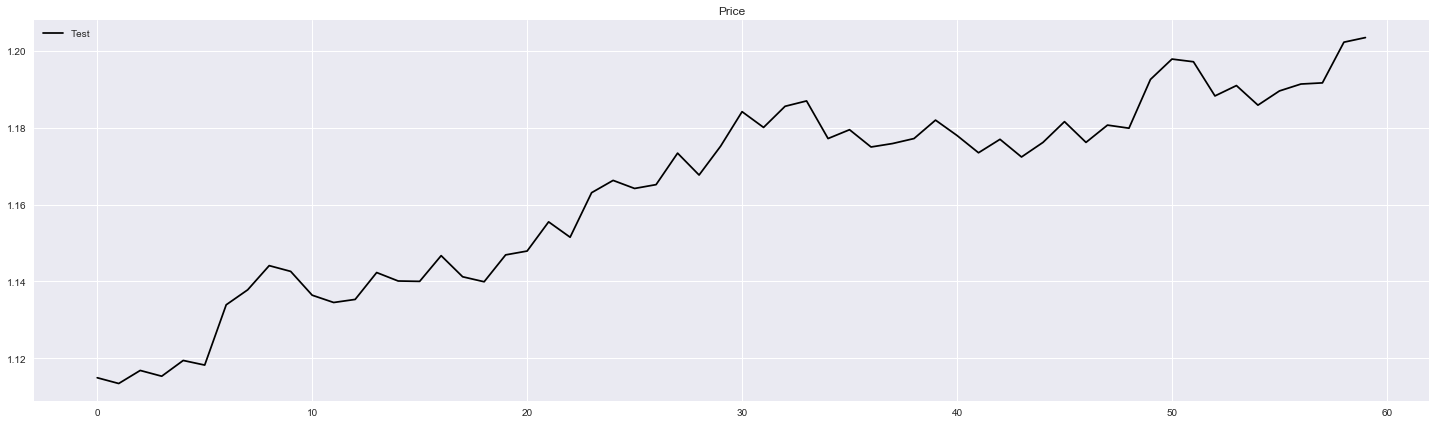

In [6]:
prices = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
plt.figure(figsize=(25,7))
plt.plot(prices,label='Test',color='black')
plt.title('Price')
plt.legend(loc='upper left')
plt.show()

### MACD

In [7]:
macd = MACD(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],12,26,9)

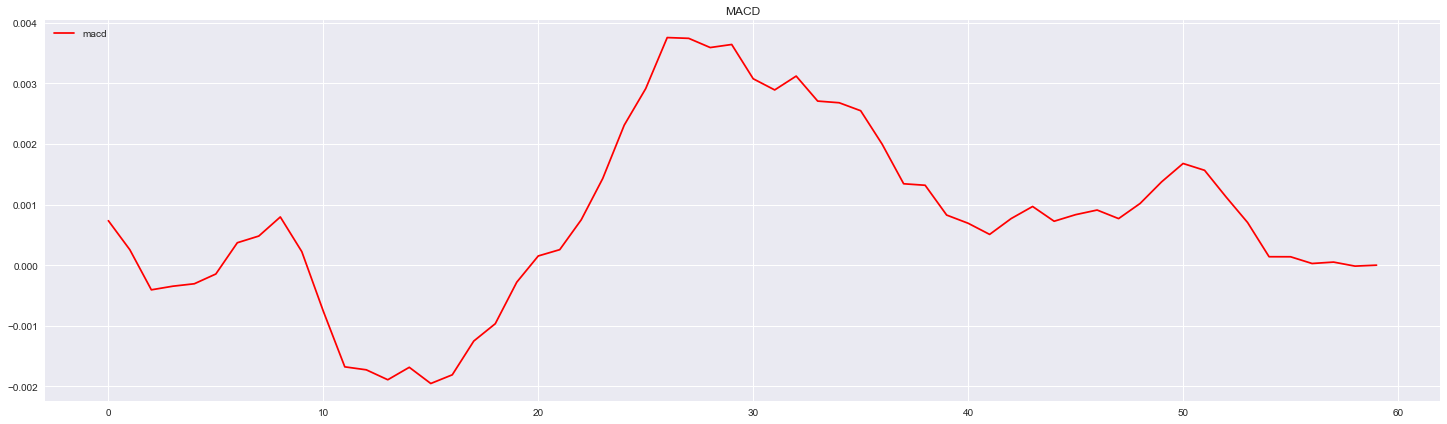

In [8]:
plt.figure(figsize=(25,7))
plt.plot(macd,label='macd',color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

### Stochastics Oscillator

In [9]:
stochastics = stochastics_oscillator(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],14)

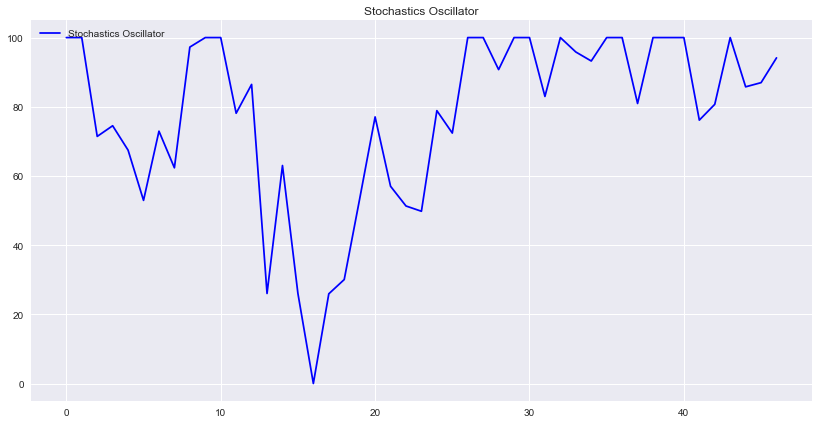

In [10]:
plt.figure(figsize=(14,7))
#First 100 points because it's too dense
plt.plot(stochastics[0:100],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='upper left')
plt.show()

### Average True Range

In [11]:
atr = ATR(df.iloc[len(df.index)-60:len(df.index)],14)

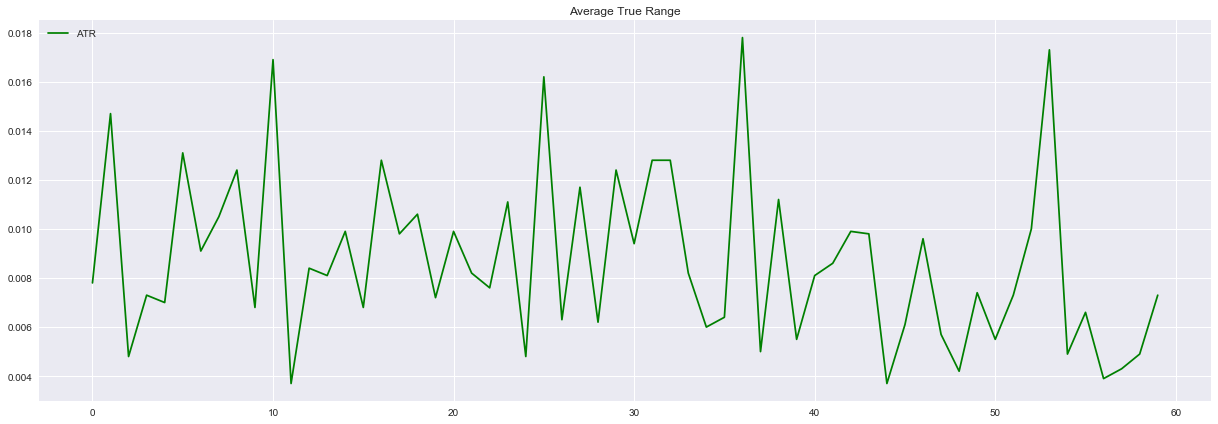

In [12]:
plt.figure(figsize=(21,7))
#First 100 points because it's too dense
plt.plot(atr[0:100],label='ATR',color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()

## Create complete DataFrame & Save Data

In [13]:
dfPriceShift = dfPrices.shift(-1)
dfPriceShift.rename(columns={'Close':'CloseTarget'}, inplace=True)

In [14]:
dfPriceShift.head(2)

,CloseTarget
2629,1.3537
2628,1.3426


In [15]:
macd = MACD(dfPrices,12,26,9)
macd.rename(columns={'Close':'MACD'}, inplace=True)

In [16]:
stochastics = stochastics_oscillator(dfPrices,14)
stochastics.rename(columns={'Close':'Stochastics'}, inplace=True)

In [17]:
atr = ATR(df,14)
atr.rename(columns={0:'ATR'}, inplace=True)

In [18]:
final_data = pd.concat([dfPrices,dfPriceShift,macd,stochastics,atr], axis=1)
# Delete the entries with missing values (where the stochastics couldn't be computed yet) because have a lot of datapoints ;)
final_data = final_data.dropna()

In [19]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2616 entries, 2616 to 1
Data columns (total 5 columns):
Close          2616 non-null float64
CloseTarget    2616 non-null float64
MACD           2616 non-null float64
Stochastics    2616 non-null float64
ATR            2616 non-null float64
dtypes: float64(5)
memory usage: 122.6 KB


In [20]:
final_data

,Close,CloseTarget,MACD,Stochastics,ATR
2616,1.3638,1.3630,0.001322,83.268482,0.0086
2615,1.3630,1.3621,0.001137,80.155642,0.0100
2614,1.3621,1.3607,0.000913,76.653696,0.0053
2613,1.3607,1.3650,0.000640,71.206226,0.0076
2612,1.3650,1.3689,0.000659,85.844749,0.0104
2611,1.3689,1.3768,0.000856,100.000000,0.0076
2610,1.3768,1.3798,0.001402,100.000000,0.0136
2609,1.3798,1.3838,0.001888,100.000000,0.0050
2608,1.3838,1.3904,0.002376,100.000000,0.0070
2607,1.3904,1.3868,0.003010,100.000000,0.0091


In [21]:
final_data.to_csv('EURUSD_TechnicalIndicators.csv',index=False)